In [26]:
import torch
torch.cuda.empty_cache() 

In [27]:
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.0.1+cu117
Torchvision version: 0.15.2+cu117
CUDA is available: True


In [28]:
import os 
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:100000"
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import cv2
os.getcwd()

'/home/yelhe/script/mt'

In [29]:
import glob
import shapely
from shapely.geometry import Polygon
import shapely.plotting

In [30]:
import pandas as pd
from PIL import Image as ima
import warnings
from pathlib import Path

In [31]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

# Add function def show_anns (borrowed from one of the Jupyter notebooks).
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    # polygons = []
    # color = []
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    # for ann in sorted_anns:
    #     m = ann['segmentation']
    #     img = np.ones((m.shape[0], m.shape[1], 3))
    #     color_mask = np.random.random((1, 3)).tolist()[0]
    #     for i in range(3):
    #         img[:,:,i] = color_mask[i]
    #     ax.imshow(np.dstack((img, m*0.35)))

### Data preparation

In [32]:
koord  = pd.read_csv('/home/yelhe/script/mt/output/koord.csv')

In [33]:
# koord.head()
name1 = koord.Nr.astype(str) + '1.jpg'
name2 = koord.Nr.astype(str) + '2.jpg'
name3 = koord.Nr.astype(str) + '3.jpg'
name4 = koord.Nr.astype(str) + '4.jpg'

In [34]:
gsv_image1 = []
gsv_image2 = []
gsv_image3 = []
gsv_image4 = []

nf1 = []
nf2 = []
nf3 = []
nf4 = []
for i in range(0,349):
    path1 = Path('/home/yelhe/data/gsv/GSV_filtered/' + name1[i])
    c1 = path1.is_file()
    path2 = Path('/home/yelhe/data/gsv/GSV_filtered/' + name2[i])
    c2 = path2.is_file()
    path3 = Path('/home/yelhe/data/gsv/GSV_filtered/' + name3[i])
    c3 = path3.is_file()
    path4 = Path('/home/yelhe/data/gsv/GSV_filtered/' + name4[i])
    c4 = path4.is_file()
    if c1 is True:
        im1 = cv2.imread("/home/yelhe/data/gsv/GSV_filtered/" + name1[i])
        im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
        gsv_image1.append(im1)
        nf1.append(name1[i])
    if c2 is True:
        im2 = cv2.imread("/home/yelhe/data/gsv/GSV_filtered/" + name2[i])
        im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
        gsv_image2.append(im2)
        nf2.append(name2[i])
    if c3 is True:
        im3 = cv2.imread("/home/yelhe/data/gsv/GSV_filtered/" + name3[i])
        im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)
        gsv_image3.append(im3)
        nf3.append(name3[i])
    if c4 is True:
        im4 = cv2.imread("/home/yelhe/data/gsv/GSV_filtered/" + name4[i])
        im4 = cv2.cvtColor(im4, cv2.COLOR_BGR2RGB)
        gsv_image4.append(im4)
        nf4.append(name4[i])

In [35]:
n1 = [s.replace('.jpg', '') for s in nf1]
n2 = [s.replace('.jpg', '') for s in nf2]
n3 = [s.replace('.jpg', '') for s in nf3]
n4 = [s.replace('.jpg', '') for s in nf4]

### Functions preparation

In [36]:
def convert_mask(masks):
    mb01 = []
    mb02 = []
    mb = []
    n = len(masks)
    for i in range(0, n):
        mb01.append(masks[i]['segmentation'])
    for i in range(0, n):
        mb02.append(mb01[i]*1)
    for i in range(0, n):
        mb.append(mb02[i].astype('uint8'))
    return mb

In [37]:
def output_mask(im):
    im1 = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    mask_r = mask_generator.generate(im1)
    mask_c = convert_mask(mask_r)
    return mask_c

In [312]:
# Function to find and plot filtered contours (find-filter-plot-contour)
# def ffpcontour(image, mask, i):
#     image_masked = cv2.bitwise_and(image,image,mask = mask[i])
#     assert image is not None, "image file could not be read, check with os.path.exists()"
#     assert mask is not None, "mask file could not be read, check with os.path.exists()"
#     # imgray = cv2.cvtColor(image_masked, cv2.COLOR_BGR2GRAY)
#     # ret, thresh = cv2.threshold(imgray, 127, 255, 0)
#     ret, thresh = cv2.threshold((mask[i]*255), 127, 255, 0)
    
#     contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     if len(contours) == 1:
#         contour_f = contours
#     else:
#         contour_f = []
#         for i in range(0, len(contours)):
#             # print(i, "len", len(contours[i]))
#             if len(contours[i]) > 80:
#                 contour_f.append(contours[i])
#     # print("filtered", "len", len(contour_f), contour_f)
#     # Plotting the filtered contour
#     # -1 is the contourIdx, (0,255,0) is color, 3 is the thickness
#     # print("raw",len(contours))
#     # print("filtered", len(contour_f))
#     img_con = cv2.drawContours(image_masked, contour_f, -1, (0,255,0), 3) 
#     plt.figure(figsize = (15,15))
#     plt.imshow(img_con)
#     plt.axis('on')
#     plt.show
#     return contour_f

# # Function to find and plot filtered contours (find-filter-plot-contour)
# def ffpcontour_noplot(image, mask, i):
#     assert image is not None, "image file could not be read, check with os.path.exists()"
#     assert mask is not None, "mask file could not be read, check with os.path.exists()"
#     # imgray = cv2.cvtColor(image_masked, cv2.COLOR_BGR2GRAY)
#     # ret, thresh = cv2.threshold(imgray, 127, 255, 0)
#     ret, thresh = cv2.threshold((mask[i]*255), 127, 255, 0)
#     contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     ll = [] # length list
#     for i in range(0, len(contours)):
#           ll.append(len(contours[i]))
#     maxl = max(ll)
#     maxindex = ll.index(maxl)
#     if (len(contours) == 1):
#         contour_f = contours
#     # elif (maxl < 80):
#     #      contour_f = contours[maxindex]
#     else:
#         contour_f = []
#         for i in range(0, len(contours)):
#             # print(i, "len", len(contours[i]))
#             if (len(contours[i]) >= 80):
#                 contour_f.append(contours[i])
#             else:
#                 contour_f = contour_f
#         # print("filtered", "len", len(contour_f), contour_f) 
#     # print("raw",len(contours))
#     # print("filtered", len(contour_f))
#     return contour_f

In [313]:
# Updated Function
# Function to find and plot filtered contours (find-filter-plot-contour)
# Run for each mask of each image
def ffpcontour_noplot(image, mask, i):
    assert image is not None, "image file could not be read, check with os.path.exists()"
    assert mask is not None, "mask file could not be read, check with os.path.exists()"
    # imgray = cv2.cvtColor(image_masked, cv2.COLOR_BGR2GRAY)
    # ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    ret, thresh = cv2.threshold((mask[i]*255), 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ll = [] # length list
    for i in range(0, len(contours)):
          ll.append(len(contours[i]))
    maxl = max(ll)
    maxindex = ll.index(maxl)
    if (len(contours) == 1) and (maxl >= 6):
        contour_f = contours
    elif (maxl>=80) :
        contour_f = []
        for i in range(0, len(contours)):
        # print(i, "len", len(contours[i]))
            if (len(contours[i]) >= 80):
                contour_f.append(contours[i])
            else:
                contour_f = contour_f
    elif (maxl >= 6):
        contour_f = []
        contour_f.append(contours[maxindex])
    else: 
        contour_f = []
    # print("filtered", "len", len(contour_f), contour_f) 
    # print("raw",len(contours))
    # print("filtered", len(contour_f))
    return contour_f

In [314]:
# Contour geometric attributes result
# For each contour
def cgr(contour):
    assert contour is not None, "image file could not be read, check with os.path.exists()"
    c = contour
    isconvex = cv2.isContourConvex(c) # Checking convexity
    (x,y), (w,h), ar = cv2.minAreaRect(c) # Rotated rectangle with minimum area
    M = cv2.moments(c) # Moments
    area = cv2.contourArea(c) # Area 
    if (M['m00'] != 0):
        cx = int(M['m10']/M['m00']) # Centroid
        cy = int(M['m01']/M['m00'])
    else:
        cx = x
        cy = y
    xs,ys,ws,hs = cv2.boundingRect(c) # Straight bounding rectangle
    aspect_ratio_wh_s = float(ws)/hs # Aspect ratio
    extent_s = float(area)/(ws*hs) # Extent
    hull = cv2.convexHull(c) # Solidity
    hull_area = cv2.contourArea(hull)
    if (hull_area != 0):
        solidity = float(area)/hull_area
    else:
        solidity = 0
    aspect_ratio_wh = float(w)/h  # Aspect ratio
    extent = float(area)/(w*h) # Extent
    (xe,ye),(MA,ma),ae = cv2.fitEllipse(c)
    ed = np.sqrt(4*area/np.pi) # Equivalent Diameter
    ratio_ell = float(ma)/MA
    perimeter = cv2.arcLength(c, True) # Arclength
    p_centroid = np.array([float(cx), float(cy)])
    p_masscenter = np.array([float(x), float(y)])
    is_cen_inside = cv2.pointPolygonTest(c, p_centroid, False) # Checking if centroid is inside
    is_mce_inside = cv2.pointPolygonTest(c, p_masscenter, False) # Checking if mass center is inside    
    return {
        'isconvex': isconvex,
        'area': area,
        'aspect_ratio_wh_s': aspect_ratio_wh_s,
        'extent_s': extent_s,
        'solidity': solidity,
        'aspect_ratio_wh': aspect_ratio_wh,
        'extent': extent,
        'ed': ed,
        'ratio_ell': ratio_ell,
        'perimeter': perimeter,
        'is_cen_inside': is_cen_inside,
        'is_mce_inside': is_mce_inside
    }
          

In [315]:
def csga(contours):
    assert contours is not None, "image file could not be read, check with os.path.exists()"
    if len(contours) == 1:
        ga = cgr(contours[0])
    else:
        gal = []
        for i in range(0, (len(contours)-1)):
            gal.append(cgr(contours[i]))
        isc = []
        al = []
        asps = []
        exts = []
        sol = []
        asp = []
        ext = []
        ed = []
        rate = []
        per = []
        isc = []
        ism = []
        for i in range(0, len(gal)):
            isc.append(gal[0]['isconvex'])
            al.append(gal[0]['area'])
            asps.append(gal[0]['aspect_ratio_wh_s'])
            exts.append(gal[0]['extent_s'])
            sol.append(gal[0]['solidity'])
            asp.append(gal[0]['aspect_ratio_wh'])
            ext.append(gal[0]['extent'])
            ed.append(gal[0]['ed'])
            rate.append(gal[0]['ratio_ell'])
            per.append(gal[0]['perimeter'])
            isc.append(gal[0]['is_cen_inside'])
            ism.append(gal[0]['is_mce_inside'])
        isconvex = np.all(isc)
        area = np.mean(al, axis = 0)
        aspect_ratio_wh_s = np.mean(asps, axis = 0)
        extent_s = np.mean(exts, axis = 0)
        solidity = np.mean(sol, axis = 0)
        aspect_ratio_wh = np.mean(asp, axis = 0)
        extent = np.mean(ext, axis = 0)
        ed = np.mean(ed, axis = 0)
        ratio_ell = np.mean(rate, axis = 0)
        perimeter = np.mean(per, axis = 0)
        is_cen_inside = np.mean(isc, axis = 0)
        is_mce_inside = np.mean(ism, axis = 0)
        ga = {
            'isconvex': isconvex,
            'area': area,
            'aspect_ratio_wh_s': aspect_ratio_wh_s,
            'extent_s': extent_s,
            'solidity': solidity,
            'aspect_ratio_wh': aspect_ratio_wh,
            'extent': extent,
            'ed': ed,
            'ratio_ell': ratio_ell,
            'perimeter': perimeter,
            'is_cen_inside': is_cen_inside,
            'is_mce_inside': is_mce_inside
        }
    return ga


In [316]:
# # mask file mf
# def feature_summary(image, mf):
#     # Generate a data frame for masks and attributes
#     df = pd.DataFrame()
#     df['mask'] = range(1, (len(mf)+1))
#     df = df.assign(gmedian = None, rmedian = None, bmedian = None,
#                    gmean = None, rmean = None, bmean = None,
#                    gstd = None, rstd = None, bstd = None,
#                    isconvex = None, area = None, aspect_ratio_wh_s = None,
#                    extent_s = None, solidity = None, aspect_ratio_wh = None,
#                    extent = None, ed = None, ratio_ell = None,
#                    perimeter = None, is_cen_inside = None, is_mce_inside = None)
#     mm = [] # masked image
#     for i in range(0, len(mf)):
#         mm.append(cv2.bitwise_and(image, image, mask = mf[i]))
#     mib = []
#     mig = []
#     mir = []
#     for i in range(0, len(mm)):
#         mib.append((mm[i][:,:,0])[np.where((mm[i][:,:,0]) != 0)])
#         mig.append((mm[i][:,:,1])[np.where((mm[i][:,:,1]) != 0)])
#         mir.append((mm[i][:,:,2])[np.where((mm[i][:,:,2]) != 0)])
#     # with warnings.catch_warnings():
#     #     warnings.simplefilter("ignore", category=RuntimeWarning)
#     #     foo = np.nanmean(x, axis=1)
#     for i in range(0, len(mm)):
#         df.at[i, 'bmean'] = np.mean(mib[i], axis = 0)
#         df.at[i,'gmean'] = np.mean(mig[i], axis = 0)
#         df.at[i,'rmean'] = np.mean(mir[i], axis = 0)
#         df.at[i,'bmedian'] = np.median(mib[i], axis = 0)
#         df.at[i,'gmedian'] = np.median(mig[i], axis = 0)
#         df.at[i,'rmedian'] = np.median(mir[i], axis = 0)
#         df.at[i,'bstd'] = np.std(mib[i], axis = 0)
#         df.at[i,'gstd'] = np.std(mig[i], axis = 0)
#         df.at[i,'rstd'] = np.std(mir[i], axis = 0)
#     for i in range(0, len(mf)):
#         df.at[i, 'isconvex'] = csga(ffpcontour_noplot(image, mf, i))['isconvex']
#         df.at[i, 'area'] = csga(ffpcontour_noplot(image, mf, i))['area']
#         df.at[i, 'aspect_ratio_wh_s'] = csga(ffpcontour_noplot(image, mf, i))['aspect_ratio_wh_s']
#         df.at[i, 'extent_s'] = csga(ffpcontour_noplot(image, mf, i))['extent_s']
#         df.at[i, 'solidity'] = csga(ffpcontour_noplot(image, mf, i))['solidity']
#         df.at[i, 'aspect_ratio_wh'] = csga(ffpcontour_noplot(image, mf, i))['aspect_ratio_wh']
#         df.at[i, 'extent'] = csga(ffpcontour_noplot(image, mf, i))['extent']
#         df.at[i, 'ed'] = csga(ffpcontour_noplot(image, mf, i))['ed']
#         df.at[i, 'ratio_ell'] = csga(ffpcontour_noplot(image, mf, i))['ratio_ell']
#         df.at[i, 'perimeter'] = csga(ffpcontour_noplot(image, mf, i))['perimeter']
#         df.at[i, 'is_cen_inside'] = csga(ffpcontour_noplot(image, mf, i))['is_cen_inside']
#         df.at[i, 'is_mce_inside'] = csga(ffpcontour_noplot(image, mf, i))['is_mce_inside']
#     return df

In [328]:
# Updated - Remove the empty contour
# mask file mf
def feature_summary(image, mf):
    # Generate a data frame for masks and attributes
    df = pd.DataFrame()
    df['mask'] = range(1, (len(mf)+1))
    df = df.assign(gmedian = None, rmedian = None, bmedian = None,
                   gmean = None, rmean = None, bmean = None,
                   gstd = None, rstd = None, bstd = None,
                   isconvex = None, area = None, aspect_ratio_wh_s = None,
                   extent_s = None, solidity = None, aspect_ratio_wh = None,
                   extent = None, ed = None, ratio_ell = None,
                   perimeter = None, is_cen_inside = None, is_mce_inside = None)
    mm = [] # masked image
    for i in range(0, len(mf)):
        mm.append(cv2.bitwise_and(image, image, mask = mf[i]))
    mib = []
    mig = []
    mir = []
    for i in range(0, len(mm)):
        mib.append((mm[i][:,:,0])[np.where((mm[i][:,:,0]) != 0)])
        mig.append((mm[i][:,:,1])[np.where((mm[i][:,:,1]) != 0)])
        mir.append((mm[i][:,:,2])[np.where((mm[i][:,:,2]) != 0)])
    # with warnings.catch_warnings():
    #     warnings.simplefilter("ignore", category=RuntimeWarning)
    #     foo = np.nanmean(x, axis=1)
    for i in range(0, len(mm)):
        df.at[i, 'bmean'] = np.mean(mib[i], axis = 0)
        df.at[i,'gmean'] = np.mean(mig[i], axis = 0)
        df.at[i,'rmean'] = np.mean(mir[i], axis = 0)
        df.at[i,'bmedian'] = np.median(mib[i], axis = 0)
        df.at[i,'gmedian'] = np.median(mig[i], axis = 0)
        df.at[i,'rmedian'] = np.median(mir[i], axis = 0)
        df.at[i,'bstd'] = np.std(mib[i], axis = 0)
        df.at[i,'gstd'] = np.std(mig[i], axis = 0)
        df.at[i,'rstd'] = np.std(mir[i], axis = 0)
    for i in range(0, len(mf)):
        con = ffpcontour_noplot(image, mf, i)
        if len(con) != 0 :
            df.at[i, 'isconvex'] = csga(con)['isconvex']
            df.at[i, 'area'] = csga(con)['area']
            df.at[i, 'aspect_ratio_wh_s'] = csga(con)['aspect_ratio_wh_s']
            df.at[i, 'extent_s'] = csga(con)['extent_s']
            df.at[i, 'solidity'] = csga(con)['solidity']
            df.at[i, 'aspect_ratio_wh'] = csga(con)['aspect_ratio_wh']
            df.at[i, 'extent'] = csga(con)['extent']
            df.at[i, 'ed'] = csga(con)['ed']
            df.at[i, 'ratio_ell'] = csga(con)['ratio_ell']
            df.at[i, 'perimeter'] = csga(con)['perimeter']
            df.at[i, 'is_cen_inside'] = csga(con)['is_cen_inside']
            df.at[i, 'is_mce_inside'] = csga(con)['is_mce_inside']
        else :
            df.at[i, 'isconvex'] = np.nan
            df.at[i, 'area'] = np.nan
            df.at[i, 'aspect_ratio_wh_s'] = np.nan
            df.at[i, 'extent_s'] = np.nan
            df.at[i, 'solidity'] = np.nan
            df.at[i, 'aspect_ratio_wh'] = np.nan
            df.at[i, 'extent'] = np.nan
            df.at[i, 'ed'] = np.nan
            df.at[i, 'ratio_ell'] = np.nan
            df.at[i, 'perimeter'] = np.nan
            df.at[i, 'is_cen_inside'] = np.nan
            df.at[i, 'is_mce_inside'] = np.nan
    # Remove the rows with na
    df = df.dropna()
    return df

In [317]:
def filter_overlap(mask):
    mb_new = mask
    mb_new1 = mask
    for i in range(0, (len(mb_new)-1)):
        for j in range((i+1), len(mb_new)):
            a = cv2.bitwise_and(mb_new[i], mb_new[j])
            al = len(np.unique(a))
            # print(i, j, "len", al)
            if al != 1:
                s1 = cv2.countNonZero(mb_new[i])
                s2 = cv2.countNonZero(mb_new[j])
                b = cv2.bitwise_or(mb_new[i], mb_new[j])
                # print(i,j, "have intersection")
                s3 = cv2.countNonZero(b)
                if s1 >= s2 :
                    # print(i,">", j)
                    if s1 == s3:
                        # print(j, "subset of", i)
                        mb_new1[j] = 0
                else:
                    # print(i,"<", j)
                    if s2 == s3:
                        # print(i, "subset of", j)
                        mb_new1[i] = 0
    emptyl = []
    for i in range(0, len(mb_new)):
        if np.all(mb_new1[i] == 0):
            emptyl.append(i)           
    mb_new1 = np.delete(mb_new1, emptyl, 0)
    # print(len(mask), len(mb_new1))
    return mb_new1


### Run workflow on generated gsv mask files

In [114]:
mask1 = []
mask2 = []
mask3 = []
mask4 = []
mask1f = []
mask2f = []
mask3f = []
mask4f = []

In [115]:
# Load all generated mask files

for i in range(0,295):
    m1 = np.load('/home/yelhe/data/gsv_output/' + n1[i] + '.npy', allow_pickle=True)
    mask1.append(m1)
    m2 = np.load('/home/yelhe/data/gsv_output/' + n2[i] + '.npy', allow_pickle=True)
    mask2.append(m2)
    m3 = np.load('/home/yelhe/data/gsv_output/' + n3[i] + '.npy', allow_pickle=True)
    mask3.append(m3)
    m4 = np.load('/home/yelhe/data/gsv_output/' + n4[i] + '.npy', allow_pickle=True)
    mask4.append(m4)


print(len(mask1), len(mask2), len(mask3), len(mask4))

295 295 295 295


In [116]:
# Load all generated filtered mask files
for i in range(0,295):
    m1 = np.load('/home/yelhe/data/gsv_output_filtered/' + n1[i] + 'f.npy', allow_pickle=True)
    mask1f.append(m1)
    m2 = np.load('/home/yelhe/data/gsv_output_filtered/' + n2[i] + 'f.npy', allow_pickle=True)
    mask2f.append(m2)
    m3 = np.load('/home/yelhe/data/gsv_output_filtered/' + n3[i] + 'f.npy', allow_pickle=True)
    mask3f.append(m3)
    m4 = np.load('/home/yelhe/data/gsv_output_filtered/' + n4[i] + 'f.npy', allow_pickle=True)
    mask4f.append(m4)

print(len(mask1f), len(mask2f), len(mask3f), len(mask4f))

295 295 295 295


0


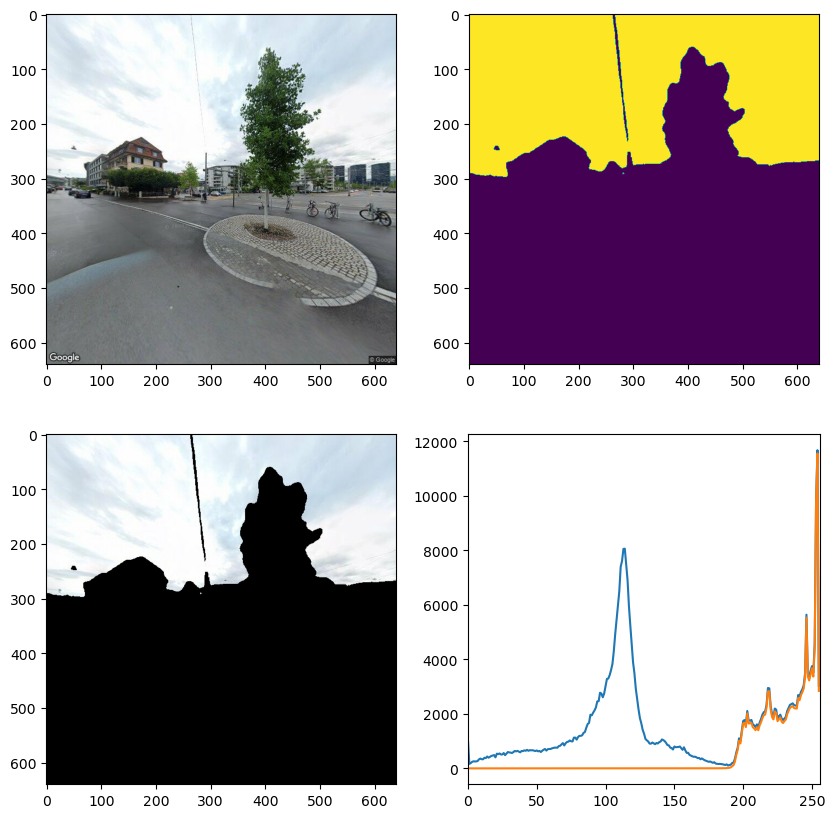

In [53]:
## i = i+1
j = 0
mb = mask1f[j]
img = gsv_image1[j]


i = 0
print(i)
maskedimg = cv2.bitwise_and(img,img,mask = mb[i])
# create a mask
hist_full = cv2.calcHist([img],[0],None,[256],[0,256])
hist_mask = cv2.calcHist([img],[0],mb[i],[256],[0,256])
plt.figure(figsize = (10,10))
plt.subplot(221), plt.imshow(img)
plt.subplot(222), plt.imshow(mb[i])
plt.subplot(223), plt.imshow(maskedimg)
plt.subplot(224), plt.plot(hist_full), plt.plot(hist_mask)
plt.xlim([0,256])
plt.show()

In [127]:
leng = []
for i in range(0,len(mb)):
    leng.append(len(ffpcontour_noplot(img, mb, i)))
print(leng)

[1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [329]:
df1 = []
for i in range(0, 10):
    df1.append(feature_summary(gsv_image1[i], mask1f[i]))
    # print(i)

0
1
2
3
4
5
6
7
8
9


In [427]:
df2 = []
df3 = []
df4 = []
for i in range(0, 10):
    df2.append(feature_summary(gsv_image2[i], mask2f[i]))
    df3.append(feature_summary(gsv_image2[i], mask2f[i]))
    df4.append(feature_summary(gsv_image2[i], mask2f[i]))
    # print(i)

In [1085]:
j = j+1
mb = mask1f[j]
img = gsv_image1[j]

In [1086]:
print(j, n1[j])

9 999000495072791


In [1087]:
df1[j].info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 0 to 60
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   mask               60 non-null     int64 
 1   gmedian            60 non-null     object
 2   rmedian            60 non-null     object
 3   bmedian            60 non-null     object
 4   gmean              60 non-null     object
 5   rmean              60 non-null     object
 6   bmean              60 non-null     object
 7   gstd               60 non-null     object
 8   rstd               60 non-null     object
 9   bstd               60 non-null     object
 10  isconvex           60 non-null     object
 11  area               60 non-null     object
 12  aspect_ratio_wh_s  60 non-null     object
 13  extent_s           60 non-null     object
 14  solidity           60 non-null     object
 15  aspect_ratio_wh    60 non-null     object
 16  extent             60 non-null     object
 17  ed  

59 label


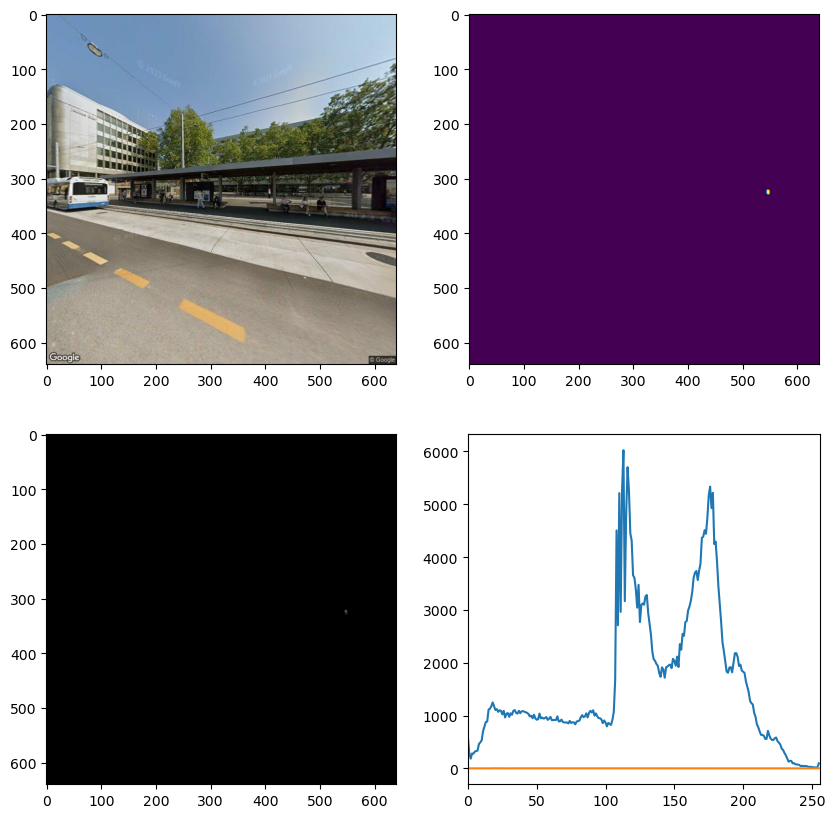

In [1149]:
t = t+1
p = ((df1[j]).iloc[t]['mask']) -1
# print(t, p)
i = t
#i = 0
print(t,'label')
maskedimg = cv2.bitwise_and(img,img,mask = mb[i])
# create a mask
hist_full = cv2.calcHist([img],[0],None,[256],[0,256])
hist_mask = cv2.calcHist([img],[0],mb[i],[256],[0,256])
plt.figure(figsize = (10,10))
plt.subplot(221), plt.imshow(img)
plt.subplot(222), plt.imshow(mb[i])
plt.subplot(223), plt.imshow(maskedimg)
plt.subplot(224), plt.plot(hist_full), plt.plot(hist_mask)
plt.xlim([0,256])
plt.show()

In [1093]:
# Labelling
# Manual Labeling
# df1[0] = df1[0].assign(label = None)
df1[0] = df1[0].assign(label = ['sky', 'greenzone_pavement', 'sky', 'tree', 'road', 'building', 'tree', 'tree',
                                'bicycle', 'bicycle', 'building', 'tree_pit', 'tag', 'building', 'bicycle', 'building',
                                'building', 'tree', 'building', 'vehicle', 'building', 'vehicle', 'tree', 'curb_tile',
                                'building', 'tree', 'building_part', 'tree', 'bicycle_part', 'bicycle', 'tree', 'vehicle',
                                'tree', 'vehicle', 'person', 'curb', 'bicycle_part', 'electric_pole', 'bicycle_parking_stand', 'curb_tile',
                                'sky_part',  'curb'])
df1[0] = df1[0].assign(Nr = n1[0])
# df1[0] = df1[0].assign(labelgroup = [])

In [1150]:
# Labelling
# Manual Labeling
# df1[1] = df1[1].assign(label = None)
df1[1] = df1[1].assign(label = ['sky', 'road', 'road', 'tree', 'tag', 'plant', 'tree', 'station_top',
                                'plant', 'road_part', 'tree', 'station_part', 'road_green_zone', 'station_ticket_machine', 'tree', 'person',
                                'pavement', 'road_part', 'road_bridge_part', 'manhole', 'tree', 'tree', 'station_part', 'station_part', 
                                'station_part', 'plant', 'road_part','station_top', 'tag',  'tree','road_bridge_stairs', 'person_legs',
                                'tree', 'tree', 'tag', 'road', 'road_part',  'station_part_and_trash_bin', 'road_sign', 'plant',  
                                'road_ground_sign', 'plant', 'plant', 'station_part', 'plant', 'road_staris', 'tree', 'station_bench', 
                                'tree', 'street_light_part', 'station_part', 'station_part', 'street_light','tree_and_sky_through_road_bridge', 'plant', 'station_bench_part',
                                'station_part', 'curb_tile', 'pavement_part'])
df1[1] = df1[1].assign(Nr = n1[1])

df1[2] = df1[2].assign(label = ['road', 'sky', 'tree', 'tree', 'building', 'tag', 'road', 'sky', 
                                'building', 'tree', 'building', 'plant', 'plant', 'parking_greenzone', 'vehicle', 'plant', 
                                'shadow', 'building', 'building', 'building', 'plant', 'vehicle_wheel', 'vehicle', 'building',
                                'plant', 'vehicle', 'plant', 'building', 'plant', 'building', 'plant', 'plant', 
                                'plant', 'mailbox', 'plant', 'plant', 'pavement_edge_tile', 'plant', 'building', 'vehicle_wheel', 
                                'vehicle_plant', 'vehicle', 'vehicle'])
df1[2] = df1[2].assign(Nr = n1[2])

df1[3] = df1[3].assign(label = ['sky', 'road', 'sky', 'plant', 'vehicle', 'other', 'vehicle', 'road_ground_sign', 
                                'vehicle', 'plant', 'vehicle', 'other', 'vehicle', 'plant', 'plant', 'other', 
                                'plant', 'other', 'plant', 'road_ground_sign', 'plant', 'building', 'other', 'plant', 
                                'plant', 'plant', 'vehicle', 'plant', 'plant', 'road_ground_sign', 'plant', 'plant', 
                                'other', 'plant', 'other', 'other', 'other', 'plant', 'other', 'vehicle', 
                                'other', 'road_ground_sign', 'other', 'other', 'plant', 'plant', 'other', 'other', 
                                'vehicle', 'tag', 'other', 'other', 'mountain', 'plant', 'plant', 'other', 
                                'fence_stick', 'other', 'street_light'])
df1[3] = df1[3].assign(Nr = n1[3])

df1[4] = df1[4].assign(label = ['sky', 'road', 'plant', 'vehicle', 'building', 'plant', 'plant', 'vehicle_wheel', 
                                'road_part', 'plant', 'plant', 'tag', 'plant', 'road', 'building_window', 'plant', 
                                'pavement', 'construction_fence', 'road_sign', 'plant', 'plant', 'road', 'other', 'road_sign', 
                                'plant', 'plant', 'plant', 'building_part', 'building_window', 'plant', 'vehicle_part', 'building_part', 
                                'other', 'road_sign_pole', 'other', 'road_sign', 'road_sign', 'construction_fence', 'plant', 'manhole', 
                                'vehicle_part', 'vehicle_part', 'building_part', 'plant', 'vehicle_part'])
df1[4] = df1[4].assign(Nr = n1[4])

df1[5] = df1[5].assign(label = ['sky', 'building', 'sky', 'blind_way', 'tag', 'railway', 'tag', 'railway_construction', 
                                'building', 'pavement_gleis', 'railway_construction', 'building_part', 'building', 'railway_construction', 'plant', 'railway_construction', 
                                'railway_construction', 'railway_construction', 'railway_construction', 'railway_construction', 'building', 'railway_construction', 'railway_construction', 'railway_construction', 
                                'railway_construction', 'plant', 'railway_construction'])
df1[5] = df1[5].assign(Nr = n1[5])

df1[6] = df1[6].assign(label = ['vehicle', 'building', 'pavement', 'building', 'building', 'sky', 'vehicle', 'plant', 
                                'building', 'building', 'curb', 'plant_vase', 'tag', 'plant', 'vehicle', 'vehicle', 
                                'road_sign', 'plant', 'road_ground_sign', 'plant_vase', 'plant', 'other', 'vehicle_wheel', 'trash_bin', 
                                'other', 'building_part', 'road_sign', 'building_part', 'plant', 'plant', 'road_edge', 'other', 
                                'plant', 'plant', 'building_part', 'plant', 'vehicle', 'vehicle', 'vehicle_wheel', 'sky_part', 
                                'street_light', 'vehicle_part', 'shadow', 'building', 'plant', 'building', 'street_light_part', 'other', 
                                'other', 'other', 'other', 'other', 'other', 'vehicle'])
df1[6] = df1[6].assign(Nr = n1[6])

df1[7] = df1[7].assign(label = ['building', 'road', 'sky', 'building', 'manhole', 'building_part', 'building_part', 'building_part', 
                                'plant', 'building_part', 'building_part', 'building_part', 'road', 'building_part', 'building_part', 'building', 
                                'building_part', 'plant', 'building_part', 'building_part', 'building_part', 'building_part', 'building_part', 'building_part', 
                                'building_part', 'building_part', 'building_part', 'building_part', 'building_part', 'building_part', 'building_part', 'building_part', 
                                'building_part', 'building_part', 'building_part', 'building_part', 'building_part', 'building_part', 'building_part', 'building_part', 
                                'building_part', 'building_part', 'building_part', 'building_part', 'building_part', 'building_part', 'building_part', 'building_part', 
                                'building_part', 'other', 'building_part', 'building_part', 'building_part', 'building_part', 'building_part', 'building_part', 
                                'building_part', 'building_part', 'plant', 'building_part', 'building_part', 'plant', 'building_part', 'manhole_tag', 
                                'plant', 'vehicle', 'building_part', 'vehicle', 'other', 'building_part', 'building_part', 'building_part', 
                                'building_part', 'building_part', 'building_part', 'building_part', 'other', 'building_part', 'plant_trunk', '', 
                                'building_part', 'building_part', 'building_part', 'building_part', 'building_part', 'building_part', 'building_part', 'vehicle', 
                                'building_part', 'vehicle', 'building_part', 'building'])
df1[7] = df1[7].assign(Nr = n1[7])

df1[8] = df1[8].assign(label = ['sky', 'building', 'road', 'pavement', 'poster', 'tag', 'fence', 'plant', 
                                'poster', 'plant', 'tag', 'curb', 'plant', 'plant', 'plant', 'fence', 
                                'plant', 'curb_tile', 'poster', 'plant', 'other', 'other', 'plant', 'curb_tile', 
                                'plant', 'plant', 'building_part', 'plant', 'sky', 'poster', 'other', 'curb_tile'])
df1[8] = df1[8].assign(Nr = n1[8])


df1[9] = df1[9].assign(Nr = n1[9])
df1[9] = df1[9].assign(label = ['sky', 'road', 'station_top', 'building', 'bus', 'tag', 'road_ground_sign', 'tag', 
                                'road', 'plant', 'manhole', 'road_ground_sign', 'station_top', 'plant', 'curb', 'station_part', 
                                'station_part', 'station_part', 'plant', 'road_ground_sign', 'street_light', 'person', 'road_ground_sign', 'building_part', 
                                'station_part', 'road_ground_sign', 'plant', 'station_part', 'tag', 'person', 'station_ticket_machine', 'plant', 
                                'tag', 'station_part', 'road_ground_sign', 'plant', 'road_ground_sign', 'bus_part', 'plant', 'person', 
                                'electric_polt', 'building_part', 'street_wire', 'person', 'road_part', 'station_part', 'station_part', 'station_sign', 
                                'building_part', 'person', 'electric_pole', 'building', 'other', 'station_part', 'other', 'other', 
                                'other', 'person', 'other', 'other'
])


# df1[0] = df1[0].assign(labelgroup = [])

In [1151]:
df1[9]

,mask,gmedian,rmedian,bmedian,gmean,rmean,bmean,gstd,rstd,bstd,...,solidity,aspect_ratio_wh,extent,ed,ratio_ell,perimeter,is_cen_inside,is_mce_inside,Nr,label
0,1,158.0,194.0,129.0,167.866005,199.0445,139.087379,21.108509,13.586172,26.713263,...,0.871205,0.151968,0.731577,82.772592,8.797464,517.504614,0.5,1.0,999000495072791,sky
1,2,152.0,137.0,162.0,145.758492,130.933042,155.321995,22.085322,22.140608,22.432384,...,0.985783,0.435055,0.703167,398.801828,4.01663,1804.499562,0.5,1.0,999000495072791,road
2,3,24.0,26.0,27.0,52.613653,54.284617,51.201487,43.1742,45.935426,37.282008,...,0.887322,0.07248,0.631904,129.554932,46.684477,1172.0904,1.0,1.0,999000495072791,station_top
3,4,172.0,159.0,174.0,155.057632,146.458107,154.594008,61.09267,63.319994,61.406278,...,0.956307,0.832512,0.70146,175.044308,3.022127,712.759447,1.0,1.0,999000495072791,building
4,5,119.0,116.0,109.0,126.04352,123.852158,122.178479,68.870372,72.013167,69.870449,...,0.975961,0.51295,0.89415,87.614846,2.849448,328.08326,1.0,1.0,999000495072791,bus
6,7,172.0,106.0,216.0,170.882692,108.309615,211.693269,8.945653,12.411777,15.124329,...,0.947856,3.769231,0.84816,35.188428,4.606629,160.752307,1.0,1.0,999000495072791,tag
7,8,98.5,90.0,101.5,130.827763,124.402314,134.066838,72.714419,73.733271,71.889308,...,0.791459,3.120944,0.681348,30.140611,3.602943,143.154328,1.0,1.0,999000495072791,road_ground_sign
8,9,190.0,178.0,196.0,189.180952,177.150635,195.493048,13.310774,14.510008,13.088138,...,0.925979,7.711774,0.57153,197.905933,13.855657,1594.021421,1.0,1.0,999000495072791,tag
9,10,90.0,47.0,82.0,92.283149,54.523695,83.597683,33.932453,37.045601,33.141999,...,0.844108,0.822664,0.638505,111.289881,1.267096,658.17366,-1.0,1.0,999000495072791,road
10,11,88.0,80.0,89.0,89.971506,81.858887,92.43962,16.588172,16.12718,17.578109,...,0.950635,3.957447,0.770991,29.294427,5.62209,138.08326,1.0,1.0,999000495072791,plant


In [305]:
ca = [2,2, 2]
maxl = max(ca)
maxindex = ca.index(maxl)
print(maxindex)
print(ca[maxindex])

0
2


In [164]:
j = 1
mb = mask1f[j]
img = gsv_image1[j]


In [165]:
print(j)

1


In [371]:
leng = []
for i in range(0,len(mb)):
    leng.append(len(ffpcontour_noplot(img, mb, i)))
print(leng)


[1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [58]:
df0_1 = feature_summary(gsv_image1[0], mask1f[0])

42


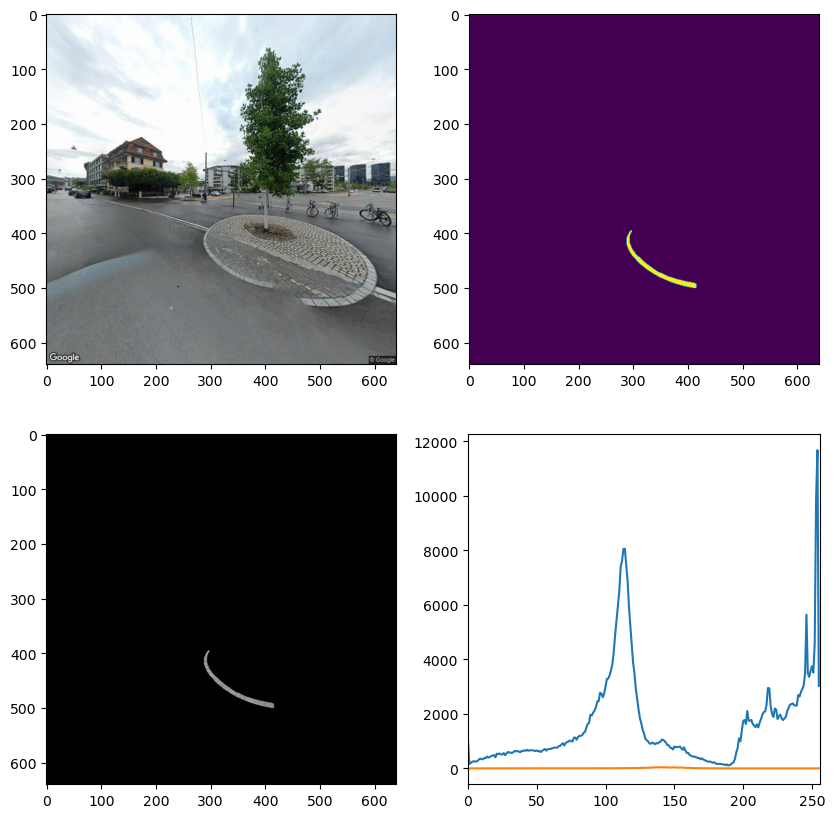

In [106]:
i = i+1
#i = 0
print(i)
maskedimg = cv2.bitwise_and(img,img,mask = mb[i])
# create a mask
hist_full = cv2.calcHist([img],[0],None,[256],[0,256])
hist_mask = cv2.calcHist([img],[0],mb[i],[256],[0,256])
plt.figure(figsize = (10,10))
plt.subplot(221), plt.imshow(img)
plt.subplot(222), plt.imshow(mb[i])
plt.subplot(223), plt.imshow(maskedimg)
plt.subplot(224), plt.plot(hist_full), plt.plot(hist_mask)
plt.xlim([0,256])
plt.show()

In [61]:
# n1[0]

'999000608525971'

In [108]:
# Manual Labeling
df0_1 = df0_1.assign(label = None)
# df = df.assign(labelgroup = None)

df0_1 = df0_1.assign(label = ['sky', 'greenzone_pavement', 'sky', 'tree', 'road', 'building', 'tree', 'tag',
                        'tree', 'bicycle', 'bicycle', 'building', 'tree_pit', 'tag', 'building', 'bicycle',
                        'building', 'building', 'tree', 'building', 'vehicle', 'building', 'vehicle', 'tree',
                        'curb_tile', 'building', 'tree', 'building_part', 'tree', 'bicycle_part', 'bicycle', 'building',
                        'vehicle', 'tree', 'vehicle', 'person', 'curb', 'tree', 'electric_pole', 'electric_pole',
                        'curb_tile', 'sky_part', 'curb'])


In [111]:
df0_1

,mask,gmedian,rmedian,bmedian,gmean,rmean,bmean,gstd,rstd,bstd,...,extent_s,solidity,aspect_ratio_wh,extent,ed,ratio_ell,perimeter,is_cen_inside,is_mce_inside,label
0,1,244.0,248.0,237.0,240.730656,245.506949,232.780832,12.440094,8.665818,17.859522,...,0.773957,0.808458,0.464789,0.777778,433.522336,2.712297,2958.881371,1.0,1.0,sky
1,2,121.0,118.0,119.0,125.207882,121.699247,123.851176,28.2125,28.452921,27.957547,...,0.63006,0.921865,2.314891,0.739277,206.695226,2.441359,1026.933108,1.0,1.0,greenzone_pavement
2,3,244.0,248.0,237.0,240.717879,245.472134,232.790564,12.579833,8.892382,17.936509,...,0.777404,0.802317,0.466354,0.781233,435.215128,2.835151,2765.91081,1.0,1.0,sky
3,4,102.0,56.0,84.0,115.255602,74.737458,98.845643,46.973404,55.825408,49.051072,...,0.706555,0.953275,1.5,0.743815,38.140217,1.540817,139.982755,1.0,1.0,tree
4,5,115.0,117.0,111.0,113.090287,114.524478,109.461159,17.588751,17.982858,16.838046,...,0.381163,0.629061,1.265193,0.384943,142.531307,2.304478,990.340181,0.5,-1.0,road
5,6,85.0,81.0,90.0,92.667168,88.452205,95.372874,38.021226,36.345329,38.52799,...,0.46958,0.748029,0.458731,0.611714,90.639827,2.378576,431.605119,1.0,1.0,building
6,7,66.0,44.0,48.0,82.736084,67.034742,67.375842,59.601482,64.222304,59.007991,...,0.582507,0.841978,0.543415,0.60851,171.619386,1.994451,813.879284,1.0,1.0,tree
7,8,38.0,38.0,37.0,57.831776,57.870494,57.676903,45.862056,45.843911,45.942668,...,0.914,1.0,0.285714,0.999271,29.543285,1.871442,125.414214,1.0,1.0,tag
8,9,36.0,25.0,27.0,42.63034,28.654296,33.778372,29.033813,20.333219,26.516614,...,0.748316,0.931378,0.320896,0.771434,75.229979,3.476463,330.308656,1.0,1.0,tree
9,10,95.0,96.0,95.5,91.539554,92.868687,92.406883,40.813544,41.026044,41.374835,...,0.619565,0.912913,0.754789,0.69619,24.095585,1.49198,90.08326,1.0,1.0,bicycle


In [ ]:
df0_1c = df0_1.loc[df0_1['label'] == 'curb']

In [ ]:
df0_1c

In [310]:
# Function to find and plot filtered contours (find-filter-plot-contour)
# Run for each mask of each image
def ffpcontour_noplot(image, mask, i):
    assert image is not None, "image file could not be read, check with os.path.exists()"
    assert mask is not None, "mask file could not be read, check with os.path.exists()"
    # imgray = cv2.cvtColor(image_masked, cv2.COLOR_BGR2GRAY)
    # ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    ret, thresh = cv2.threshold((mask[i]*255), 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ll = [] # length list
    for i in range(0, len(contours)):
          ll.append(len(contours[i]))
    maxl = max(ll)
    maxindex = ll.index(maxl)
    if (len(contours) == 1) and (maxl >= 6):
        contour_f = contours
    elif (maxl>=80) :
        contour_f = []
        for i in range(0, len(contours)):
        # print(i, "len", len(contours[i]))
            if (len(contours[i]) >= 80):
                contour_f.append(contours[i])
            else:
                contour_f = contour_f
    elif (maxl >= 6):
        contour_f = []
        contour_f.append(contours[maxindex])
    else: 
        contour_f = []
    # print("filtered", "len", len(contour_f), contour_f) 
    # print("raw",len(contours))
    # print("filtered", len(contour_f))
    return contour_f

In [274]:
j = 1
mb = mask1f[j]
img = gsv_image1[j]


In [275]:

print(j)
t = 32
print(t)
ret, thresh = cv2.threshold((mb[t]*255), 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
ll = [] # length list
for i in range(0, len(contours)):
    ll.append(len(contours[i]))
maxl = max(ll)
maxindex = ll.index(maxl)
print(ll)
print(maxindex)

1
32
[38, 37]
0


32


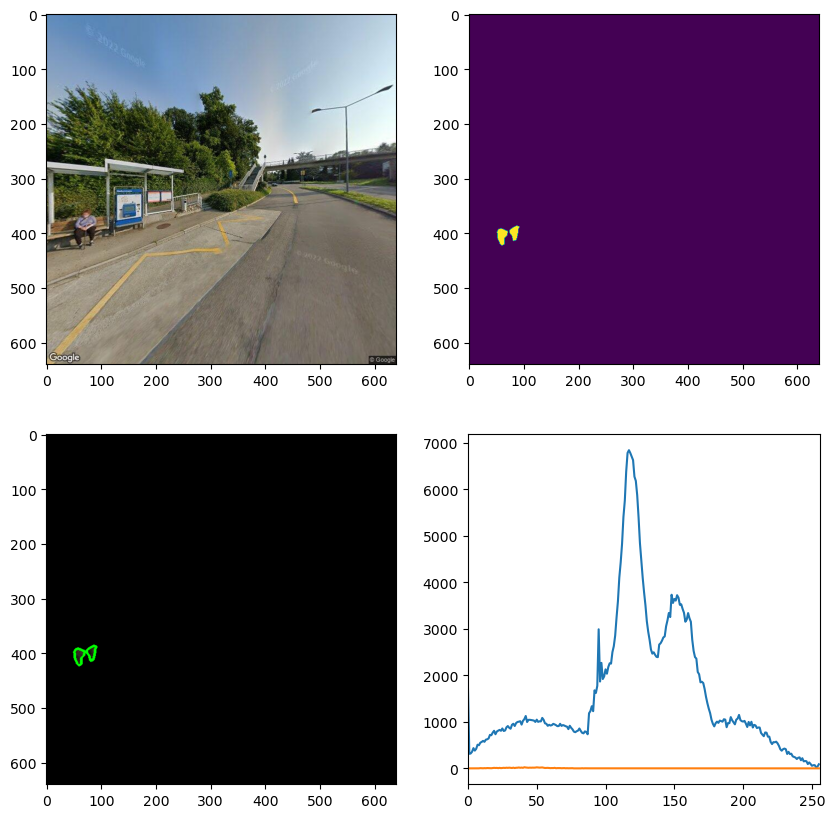

In [253]:
i = t
#i = 0
print(i)
maskedimg = cv2.bitwise_and(img,img,mask = mb[i])
img_con = cv2.drawContours(maskedimg, contours, -1, (0,255,0), 3) 
# create a mask
hist_full = cv2.calcHist([img],[0],None,[256],[0,256])
hist_mask = cv2.calcHist([img],[0],mb[i],[256],[0,256])
plt.figure(figsize = (10,10))
plt.subplot(221), plt.imshow(img)
plt.subplot(222), plt.imshow(mb[i])
plt.subplot(223), plt.imshow(img_con)
plt.subplot(224), plt.plot(hist_full), plt.plot(hist_mask)
plt.xlim([0,256])
plt.show()

In [276]:
contours

(array([[[ 57, 392]],
 
        [[ 56, 393]],
 
        [[ 54, 393]],
 
        [[ 53, 394]],
 
        [[ 53, 395]],
 
        [[ 52, 396]],
 
        [[ 52, 397]],
 
        [[ 51, 398]],
 
        [[ 51, 399]],
 
        [[ 52, 400]],
 
        [[ 52, 409]],
 
        [[ 53, 410]],
 
        [[ 53, 412]],
 
        [[ 54, 413]],
 
        [[ 54, 414]],
 
        [[ 55, 415]],
 
        [[ 55, 416]],
 
        [[ 56, 417]],
 
        [[ 56, 419]],
 
        [[ 59, 422]],
 
        [[ 61, 422]],
 
        [[ 62, 421]],
 
        [[ 63, 421]],
 
        [[ 64, 420]],
 
        [[ 64, 409]],
 
        [[ 69, 404]],
 
        [[ 69, 401]],
 
        [[ 70, 400]],
 
        [[ 70, 397]],
 
        [[ 69, 396]],
 
        [[ 67, 396]],
 
        [[ 66, 395]],
 
        [[ 65, 395]],
 
        [[ 64, 394]],
 
        [[ 63, 394]],
 
        [[ 62, 393]],
 
        [[ 60, 393]],
 
        [[ 59, 392]]], dtype=int32),
 array([[[ 86, 387]],
 
        [[ 85, 388]],
 
        [[ 84, 388]],
 
   

In [311]:
print(j)
leng = []
for i in range(0,len(mb)):
    leng.append(len(ffpcontour_noplot(img, mb, i)))
print(leng)
print(len(mb), len(leng))

1
[2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
60 60
